# This notebook is designed for teaching/testing purposes to help you visualize the tensor shapes that go through each module

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [2]:
# config file
from config import ModelConfig, TrainConfig
cfg = ModelConfig()
tcfg = TrainConfig()
print(cfg)
print(tcfg)

# import the tokenizer specified by cfg
from tools import import_from_nested_path
imported_objects = import_from_nested_path(['custom_tokenizers', cfg.tokenizer], 'tokenizer', ['get_tokenizer'])
get_tokenizer = imported_objects.get('get_tokenizer')
tokenizer = get_tokenizer(size = 512) # assuming 'bpe', size options are 512, 1024 and 2048

import random
import torch

ModelConfig(dim=96, device='mps', linear_bias=False, out_weight_share=True, pos_enc_type='RoPE', theta=10000, tokenizer='bpe_tinyStories', vocab_len=2048, num_layers=8, second_resid_norm=False, mlp_hidden_mult=4, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=2, num_kv_heads=1, head_dim=48, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06)
TrainConfig(model_name='2024-07-01|23-45-54', dataset_name='noanabeshima/TinyStoriesV2', data_subset=None, streaming=False, micro_batch_size=8, grad_accum_steps=8, max_iters=10, eval_interval=2, eval_samples=1, checkpoint_interval=None, beta1=0.9, beta2=0.95, epsilon=1e-08, weight_decay=0.05, grad_clip=1.0, lr_init=0.0001, lr_max=0.1, lr_min=0.01, warmup_iters=1, final_flat_iters=0, anneal_type='cos', num_restarts=0, T_mult=2)


# Norms

In [3]:
from modules.norm import Norm

In [4]:
%%time

### RMSNorm

# Create an instance of RMSNorm
module = Norm(cfg.dim, 'RMSNorm').to(cfg.device)

# let's take a look
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

# Initially, logging is disabled by default
module.enable_logging()

### Optionally disabling printing for sub-functions
#module.disable_function_logging('CosineNorm')
#module.disable_function_logging('LayerNorm')
#module.disable_function_logging('RMSNorm')

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

# Call the forward method - logging will occur
output = module(x)

# Disable logging. 
# This isn't actually necessary since we won't be using this object again but that's how you'd do it
module.disable_logging()

# clearing up ram jic we're training later
del module, x, output

number of parameters: 0.19K
Norm()

====================Entering Norm.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.438/4.463

====================Entering Norm.RMSNorm====================
Inputs:
Tensor 'x' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.438/4.463

Outputs:
Tensor 'output' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.107/4.442
====================Exiting Norm.RMSNorm====================

Outputs:
Tensor 'output' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.107/4.442
====================Exiting Norm.forward====================
CPU times: user 70.3 ms, sys: 54 ms, total: 124 ms
Wall time: 155 ms


In [5]:
%%time

# LayerNorm
module = Norm(cfg.dim, 'LayerNorm').to(cfg.device)
module.enable_logging()

# you can also have it optionally print out all tensors in full
module.enable_full_tensor_printing()
# i recommend only doing this with very small toy values for your hyperparameters, otherwise this gets too big

### Optionally disabling printing for sub-functions
#module.disable_function_logging('CosineNorm')
#module.disable_function_logging('LayerNorm')
#module.disable_function_logging('RMSNorm')

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x)
module.disable_logging()
del module, x, output


====================Entering Norm.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.717/4.219
Full tensor content:
tensor([[[-3.9557e-01,  7.7494e-02, -2.5963e-01,  ...,  1.6729e+00,
          -4.1356e-01, -1.6519e+00],
         [ 2.7144e-01,  3.3473e-01,  7.4003e-01,  ..., -1.1379e+00,
           6.1507e-01,  8.3002e-01],
         [-1.1509e+00, -6.2294e-01, -2.8028e-02,  ...,  1.6319e+00,
          -8.4013e-01,  7.8838e-01],
         ...,
         [ 2.3112e-01, -2.0785e+00, -1.8716e-01,  ..., -4.1410e-01,
          -2.6546e-01,  5.2926e-01],
         [-3.2608e-01, -6.3929e-01,  5.6020e-01,  ..., -9.2344e-02,
           1.7099e+00, -1.1762e+00],
         [-7.8820e-04,  5.4825e-01, -1.1376e+00,  ..., -6.5838e-01,
          -1.3714e+00, -1.6825e-01]],

        [[ 4.9750e-01,  7.8290e-01,  6.6976e-01,  ...,  5.9991e-01,
           2.8689e-01, -2.1704e-01],
         [ 1.9792e-01,  1.9939e+00, -2.1671e+00,  ...,

# Attention

In [6]:
from modules.attention import SelfAttention, PrecomputeRotaryFrequencies

In [7]:
%%time

# first up let's look at training

# Create an instance of multi-head self-attention
module = SelfAttention(cfg.dim, cfg.head_dim, cfg.num_q_heads, cfg.num_kv_heads, cfg.max_seq_len, cfg.linear_bias, device=cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

# Initially, logging is disabled by default
module.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

### Optionally disabling printing for sub-functions
#module.disable_function_logging('apply_precompute_freqs')
#module.disable_function_logging('reshape_for_broadcast')
#module.disable_function_logging('match_headcount')
#module.disable_function_logging('attend')
#module.disable_function_logging('calc_output')

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).triu(diagonal=1)
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

# Call the forward method - logging will occur
output = module(x, freqs, mask, training=True)

# Disable logging. 
# This isn't actually necessary since we won't be using this object again but that's how you'd do it
module.disable_logging()

# clearing up ram jic we're training later
del module, freqs, mask, x, output

number of parameters: 27.65K
SelfAttention(
  (Wq): Linear(in_features=96, out_features=96, bias=False)
  (Wk): Linear(in_features=96, out_features=48, bias=False)
  (Wv): Linear(in_features=96, out_features=48, bias=False)
  (Wo): Linear(in_features=96, out_features=96, bias=False)
)

====================Entering SelfAttention.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.616/4.731
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: -1.000/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: -1.000/1.000
Tensor 'mask' shape: torch.Size([512, 512]), dtype: torch.bool, device: mps:0, min/max: 0.000/1.000
Other-type 'cache_len': Type=NoneType, Value=None
Other-type 'kv_cache': Type=NoneType, Value=None
Bool 'training': Value=True

====================Entering SelfAttention.apply_ro

In [8]:
%%time

# now let's do it for inference

module = SelfAttention(cfg.dim, cfg.head_dim, cfg.num_q_heads, cfg.num_kv_heads, cfg.max_seq_len, cfg.linear_bias, device=cfg.device)
module.enable_logging()
#module.disable_function_logging('apply_precompute_freqs')
#module.disable_function_logging('reshape_for_broadcast')
#module.disable_function_logging('match_headcount')
#module.disable_function_logging('attend')
#module.disable_function_logging('calc_output')

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).triu(diagonal=1)
# setting up for kv caching
context_chunk_len = cfg.max_seq_len // 4
cache_len = random.randint(1, 3 * context_chunk_len)
seq_len = cache_len + context_chunk_len
kv_cache = {
    'k': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
    'v': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device)
}
# need to extend the mask with zeros for the cached values
mask = torch.nn.functional.pad(mask[:context_chunk_len, :context_chunk_len], (cache_len, 0, 0, 0), value=False).bool()
x = torch.randn(tcfg.micro_batch_size,context_chunk_len,cfg.dim).to(cfg.device)

# Call the forward method - logging will occur
output = module(x, freqs, mask, cache_len, kv_cache)

# Disable logging. 
# This isn't actually necessary since we won't be using this object again but that's how you'd do it
module.disable_logging()

# clearing up ram jic we're training later
del module, freqs, mask, cache_len, context_chunk_len, seq_len, kv_cache, x, output


====================Entering SelfAttention.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 128, 96]), dtype: torch.float32, device: mps:0, min/max: -4.549/4.476
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: -1.000/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: -1.000/1.000
Tensor 'mask' shape: torch.Size([128, 495]), dtype: torch.bool, device: mps:0, min/max: 0.000/1.000
Integer 'cache_len': Value=367
Dict 'kv_cache':
    Tensor 'kv_cache[k]' shape: torch.Size([8, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: 0.000/0.000
    Tensor 'kv_cache[v]' shape: torch.Size([8, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: 0.000/0.000
Bool 'training': Value=False

====================Entering SelfAttention.apply_rotary_pos_emb====================
Inputs:
Tensor 'q' shape: torch.Size([8, 128, 2, 48]), dtype: tor

# Multi-Layer Perceptron

In [9]:
from modules.mlp import MLP

In [10]:
%%time

# GeGLU
module = MLP(
    cfg.dim, 
    int(cfg.dim * cfg.mlp_hidden_mult * 2/3), 
    cfg.dim, 
    'GeLU', 
    gated=True, 
    bias=cfg.linear_bias, 
    dropout_rate = 0.1
).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)
module.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x, training=True)
module.disable_logging()
del module, x, output

number of parameters: 73.73K
MLP(
  (Wup): Linear(in_features=96, out_features=256, bias=False)
  (Wgate): Linear(in_features=96, out_features=256, bias=False)
  (Wdown): Linear(in_features=256, out_features=96, bias=False)
  (nonlinearity): GELU(approximate='none')
)

====================Entering MLP.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.755/4.784
Bool 'training': Value=True

Outputs:
Tensor 'output' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -0.714/0.729
====================Exiting MLP.forward====================
CPU times: user 31.8 ms, sys: 3.94 ms, total: 35.7 ms
Wall time: 38 ms


In [11]:
%%time

# not gated, testing every other nonlinearity
module = MLP(
    cfg.dim, 
    cfg.dim * cfg.mlp_hidden_mult, 
    cfg.dim, 
    'ReLU', 
    gated=False, 
    bias=True, 
    dropout_rate = 0.1
).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)
module.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)
output = module(x, training=True)
module.disable_logging()
del module, x, output

number of parameters: 74.21K
MLP(
  (Wup): Linear(in_features=96, out_features=384, bias=True)
  (Wdown): Linear(in_features=384, out_features=96, bias=True)
  (nonlinearity): ReLU()
)

====================Entering MLP.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.470/5.160
Bool 'training': Value=True

Outputs:
Tensor 'output' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -1.321/1.106
====================Exiting MLP.forward====================
CPU times: user 33.1 ms, sys: 5.43 ms, total: 38.5 ms
Wall time: 220 ms


# ResidualLayer

In [12]:
from modules.layer import Layer

In [13]:
%%time

# TRAINING
module = Layer(cfg).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

module.enable_logging()
#module.disable_function_logging('attn_connect')
#module.disable_function_logging('mlp_connect')
### enabling printing for sub-modules
#module.pre_attn_norm.enable_logging()
#module.attn.enable_logging()
#module.post_attn_norm.enable_logging()
#module.pre_mlp_norm.enable_logging()
#module.mlp.enable_logging()
#module.post_mlp_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).triu(diagonal=1)
mask = torch.triu(mask, diagonal=1)
x = torch.randn(tcfg.micro_batch_size,cfg.max_seq_len,cfg.dim).to(cfg.device)

output = module(x, freqs, mask, training=True)
module.disable_logging()
del module,freqs, mask, x, output

number of parameters: 101.76K
Layer(
  (pre_attn_norm): Norm()
  (attn): SelfAttention(
    (Wq): Linear(in_features=96, out_features=96, bias=False)
    (Wk): Linear(in_features=96, out_features=48, bias=False)
    (Wv): Linear(in_features=96, out_features=48, bias=False)
    (Wo): Linear(in_features=96, out_features=96, bias=False)
  )
  (pre_mlp_norm): Norm()
  (mlp): MLP(
    (Wup): Linear(in_features=96, out_features=256, bias=False)
    (Wgate): Linear(in_features=96, out_features=256, bias=False)
    (Wdown): Linear(in_features=256, out_features=96, bias=False)
    (nonlinearity): SiLU()
  )
)

====================Entering Layer.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 512, 96]), dtype: torch.float32, device: mps:0, min/max: -4.543/4.487
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: -1.000/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, de

In [14]:
%%time

# INFERENCE
module = Layer(cfg).to(cfg.device)
print("number of parameters: %.2fK" % (module.get_num_params()/1e3,))
print(module)

module.enable_logging()
#module.disable_function_logging('attn_connect')
#module.disable_function_logging('mlp_connect')
#module.pre_attn_norm.enable_logging()
#module.attn.enable_logging()
#module.post_attn_norm.enable_logging()
#module.pre_mlp_norm.enable_logging()
#module.mlp.enable_logging()
#module.post_mlp_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

# precompute RoPE frequencies, causal mask, and dummy input data
if cfg.pos_enc_type == 'RoPE':
    precompute_freqs = PrecomputeRotaryFrequencies(cfg.head_dim, cfg.max_seq_len, cfg.theta, cfg.device)
    freqs = precompute_freqs()
else:
    freqs = None
mask = torch.ones(cfg.max_seq_len, cfg.max_seq_len, dtype=torch.bool, device=cfg.device).triu(diagonal=1)
mask = torch.triu(mask, diagonal=1)
# setting up for kv caching
cache_len = cfg.max_seq_len // 3
context_chunk_len = cfg.max_seq_len // 4
seq_len = cache_len + context_chunk_len
kv_cache = {
    'k': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
    'v': torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device)
}
# need to extend the mask with zeros for the cached values
mask = torch.nn.functional.pad(mask[:context_chunk_len, :context_chunk_len], (cache_len, 0, 0, 0), value=False).bool()
# these don't use seq_len because those entries should already be in the kv cache
#freqs_cis = freqs_cis[:context_chunk_len]
x = torch.randn(tcfg.micro_batch_size,context_chunk_len,cfg.dim).to(cfg.device)

output = module(x, freqs, mask, cache_len, kv_cache)
module.disable_logging()
del module, freqs, mask, cache_len, context_chunk_len, seq_len, kv_cache, x, output

number of parameters: 101.76K
Layer(
  (pre_attn_norm): Norm()
  (attn): SelfAttention(
    (Wq): Linear(in_features=96, out_features=96, bias=False)
    (Wk): Linear(in_features=96, out_features=48, bias=False)
    (Wv): Linear(in_features=96, out_features=48, bias=False)
    (Wo): Linear(in_features=96, out_features=96, bias=False)
  )
  (pre_mlp_norm): Norm()
  (mlp): MLP(
    (Wup): Linear(in_features=96, out_features=256, bias=False)
    (Wgate): Linear(in_features=96, out_features=256, bias=False)
    (Wdown): Linear(in_features=256, out_features=96, bias=False)
    (nonlinearity): SiLU()
  )
)

====================Entering Layer.forward====================
Inputs:
Tensor 'x' shape: torch.Size([8, 128, 96]), dtype: torch.float32, device: mps:0, min/max: -4.284/4.109
Dict 'freqs':
    Tensor 'freqs[cos]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, device: mps:0, min/max: -1.000/1.000
    Tensor 'freqs[sin]' shape: torch.Size([1, 512, 1, 48]), dtype: torch.float32, de

# Full Model

In [15]:
from modules.model import Model

In [16]:
%%time

# TRAINING
module = Model(cfg).to(cfg.device)
print("number of parameters: %.2fM" % (module.get_num_params()/1e6,))
print(module)

module.enable_logging()
### enabling printing for sub-modules
#module.precompute_freqs.enable_logging() # only un-comment this line if using RoPE
#module.layers[0].enable_logging()
for i in range(cfg.num_layers):
    module.layers[i].enable_logging()
module.final_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

input_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len)).to(cfg.device)
target_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len)).to(cfg.device)

output, loss = module(input_token_ids, target_token_ids=target_token_ids)
print(loss)
del module, input_token_ids, target_token_ids, output, loss

number of parameters: 1.01M
Model(
  (precompute_freqs): PrecomputeRotaryFrequencies()
  (token_embedder): Embedding(2048, 96)
  (layers): ModuleList(
    (0-7): 8 x Layer(
      (pre_attn_norm): Norm()
      (attn): SelfAttention(
        (Wq): Linear(in_features=96, out_features=96, bias=False)
        (Wk): Linear(in_features=96, out_features=48, bias=False)
        (Wv): Linear(in_features=96, out_features=48, bias=False)
        (Wo): Linear(in_features=96, out_features=96, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=96, out_features=256, bias=False)
        (Wgate): Linear(in_features=96, out_features=256, bias=False)
        (Wdown): Linear(in_features=256, out_features=96, bias=False)
        (nonlinearity): SiLU()
      )
    )
  )
  (final_norm): Norm()
  (output): Linear(in_features=96, out_features=2048, bias=False)
  (criterion): CrossEntropyLoss()
)

====================Entering Model.forward====================
Inp

In [17]:
%%time

# Inference
module = Model(cfg).to(cfg.device)
print("number of parameters: %.2fM" % (module.get_num_params()/1e6,))
print(module)

module.enable_logging()
### enabling printing for sub-modules
#for i in range(cfg.num_layers):
    #module.layers[i].enable_logging()
#module.final_norm.enable_logging()

# optionally enabling printing of every single input/output tensor
#module.enable_full_tensor_printing()

input_token_ids = torch.randint(tokenizer.vocab_len, (tcfg.micro_batch_size, cfg.max_seq_len // 4)).to(cfg.device)
kv_cache = [{ # Initialize kv caches for each layer
                "k": torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
                "v": torch.zeros((tcfg.micro_batch_size, cfg.max_seq_len, cfg.num_kv_heads, cfg.head_dim), device=cfg.device),
            } for _ in range(cfg.num_layers)]

output, kv_cache = module(input_token_ids, cache_len = cfg.max_seq_len // 3, kv_cache = kv_cache)

del module, input_token_ids, kv_cache, output

number of parameters: 1.01M
Model(
  (precompute_freqs): PrecomputeRotaryFrequencies()
  (token_embedder): Embedding(2048, 96)
  (layers): ModuleList(
    (0-7): 8 x Layer(
      (pre_attn_norm): Norm()
      (attn): SelfAttention(
        (Wq): Linear(in_features=96, out_features=96, bias=False)
        (Wk): Linear(in_features=96, out_features=48, bias=False)
        (Wv): Linear(in_features=96, out_features=48, bias=False)
        (Wo): Linear(in_features=96, out_features=96, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=96, out_features=256, bias=False)
        (Wgate): Linear(in_features=96, out_features=256, bias=False)
        (Wdown): Linear(in_features=256, out_features=96, bias=False)
        (nonlinearity): SiLU()
      )
    )
  )
  (final_norm): Norm()
  (output): Linear(in_features=96, out_features=2048, bias=False)
  (criterion): CrossEntropyLoss()
)

====================Entering Model.forward====================
Inp

# Learning Rate Schedule Display
thought i'd make somewhere to help you visualize what the learning rate schedule settings you've got look like

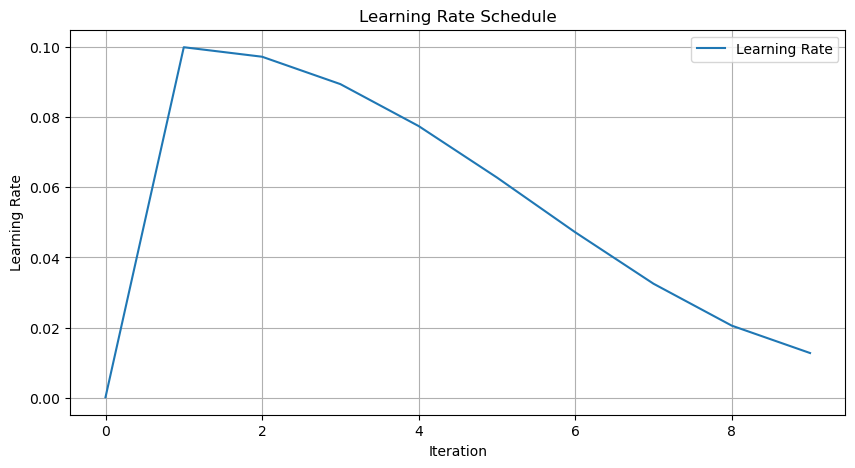

In [18]:
import matplotlib.pyplot as plt
from train import scheduler_lambda
from config import TrainConfig
tcfg = TrainConfig()
    
# Generate learning rate values
lrs = [scheduler_lambda(i) for i in range(tcfg.max_iters)]
    
# Plot the learning rates
plt.figure(figsize=(10, 5))
plt.plot(lrs, label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()
plt.show()